## Covid vaccine symptoms

We've all obviously heard a lot about covid over the past year. And more recently, we've been hearing a lot about the various covid vaccines. It's likely you're even among the vaccinated population! While vaccines are pretty great, they often result in side effects, some of which can be severe. But, by tracking these more serious events, we can analyse the data to look for patterns and use the resulting information to guide research for how to make vaccines safer.

The US government Vaccine Adverse Event Reporting System (VAERS) is a program to report when possible adverse events occur after receiving a vaccine. With the first covid vaccines becoming available in the US (outside of a trial) in December 2020, the first reports of associated events were recorded. 


### Data source

The data was sourced from the Vaccine Adverse Event Reporting System ([VAERS](https://vaers.hhs.gov)). The data is available to download from the website in CSV format. For this analysis, all the data has been saved locally. A cleaned version of the dataset is available in the project repository.

In [1]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data preparation

We'll do the preparation in two steps: first load and concatenate the DataFrrames. Then do a first pass at filtering to select the vaccines of interest and the columns to use in the analysis.

### Load the data

The downloaded data consists of three `csv` files for each year, with the `VAERS_ID` column as the one present in all three files. After concatenating the data frames for the two years together, we'll merge on the ID column.

In [2]:
# Read in the data

# load 2020 files
data_2020 = pd.read_csv('2020VAERSData/2020VAERSDATA.csv')
symptoms_2020 = pd.read_csv('2020VAERSData/2020VAERSSYMPTOMS.csv')
vax_2020 = pd.read_csv('2020VAERSData/2020VAERSVAX.csv')

# load 2021 files
data_2021 = pd.read_csv('2021VAERSData/2021VAERSDATA.csv', low_memory=False) # mixed dtypes
symptoms_2021 = pd.read_csv('2021VAERSData/2021VAERSSYMPTOMS.csv')
vax_2021 = pd.read_csv('2021VAERSData/2021VAERSVAX.csv')

# Concatenate DataFrames
vax = pd.concat([vax_2020, vax_2021])
data = pd.concat([data_2020, data_2021])
symptoms = pd.concat([symptoms_2020, symptoms_2021])

In [3]:
# Merge on 'VAERS_ID'
temp_merge = pd.merge(vax, data, on='VAERS_ID')
data_all = pd.merge(temp_merge, symptoms, on='VAERS_ID')

data_all.head()

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,RECVDATE,STATE,...,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,855017,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,2,SYR,LA,ZOSTER (SHINGRIX),01/01/2020,HI,...,Arthralgia,22.1,Chills,22.1,Injection site pain,22.1,Pyrexia,22.1,NaN,NaN
1,855018,UNK,UNKNOWN MANUFACTURER,NaN,1,IM,RA,VACCINE NOT SPECIFIED (OTHER),01/01/2020,WI,...,Chills,22.1,Fatigue,22.1,Hypertension,22.1,Hypoaesthesia,22.1,Injected limb mobility decreased,22.1
2,855018,UNK,UNKNOWN MANUFACTURER,NaN,1,IM,RA,VACCINE NOT SPECIFIED (OTHER),01/01/2020,WI,...,Muscular weakness,22.1,Pain in extremity,22.1,Pyrexia,22.1,Tremor,22.1,Vertigo,22.1
3,855019,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,ZOSTER (SHINGRIX),01/01/2020,NaN,...,Pain,22.1,Pruritus,22.1,Rash,22.1,NaN,NaN,NaN,NaN
4,855020,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,IM,LA,ZOSTER (SHINGRIX),01/01/2020,TX,...,Chills,22.1,Influenza like illness,22.1,Myalgia,22.1,Pain in extremity,22.1,Pyrexia,22.1


### 

Now that we have vaccine event information for 2020-2021, we want to filter out just the covid vaccines of interest; there are three approved for use in the US at this time, so VAERS only includes data for those vaccines.

In [4]:
# Filter for COVID19 vaccines only
vax_filter = data_all['VAX_MANU'].str.contains('BIONTECH|MODERNA|JANSSEN')
covid = data_all[vax_filter]

covid['VAX_MANU'].unique()

array(['PFIZER\\BIONTECH', 'MODERNA', 'JANSSEN'], dtype=object)

### Column selection

We don't want or need to keep all of the columns to fit the model, so let's do some filtering. Based on the VAERS user guide, we selected columns with vaccine information (manufacturer), physical information (age, sex) and symptom columns (symptoms and when they started relative to vaccination).

In [5]:
# List all of the columns 
covid.columns

Index(['VAERS_ID', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES',
       'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME', 'RECVDATE', 'STATE', 'AGE_YRS',
       'CAGE_YR', 'CAGE_MO', 'SEX', 'RPT_DATE', 'SYMPTOM_TEXT', 'DIED',
       'DATEDIED', 'L_THREAT', 'ER_VISIT', 'HOSPITAL', 'HOSPDAYS', 'X_STAY',
       'DISABLE', 'RECOVD', 'VAX_DATE', 'ONSET_DATE', 'NUMDAYS', 'LAB_DATA',
       'V_ADMINBY', 'V_FUNDBY', 'OTHER_MEDS', 'CUR_ILL', 'HISTORY',
       'PRIOR_VAX', 'SPLTTYPE', 'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT',
       'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES', 'SYMPTOM1', 'SYMPTOMVERSION1',
       'SYMPTOM2', 'SYMPTOMVERSION2', 'SYMPTOM3', 'SYMPTOMVERSION3',
       'SYMPTOM4', 'SYMPTOMVERSION4', 'SYMPTOM5', 'SYMPTOMVERSION5'],
      dtype='object')

In [6]:
# Columns to keep in the analysis
cols_keep = ['VAERS_ID', 'VAX_MANU','AGE_YRS', 'SEX', 'NUMDAYS', 
             'SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4',  'SYMPTOM5']

# Filter on selected columns
covid_subset = covid[cols_keep].copy()


In [7]:
covid_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216580 entries, 54290 to 274153
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   VAERS_ID  216580 non-null  int64  
 1   VAX_MANU  216580 non-null  object 
 2   AGE_YRS   199013 non-null  float64
 3   SEX       216580 non-null  object 
 4   NUMDAYS   196946 non-null  float64
 5   SYMPTOM1  216580 non-null  object 
 6   SYMPTOM2  176412 non-null  object 
 7   SYMPTOM3  140624 non-null  object 
 8   SYMPTOM4  107078 non-null  object 
 9   SYMPTOM5  79405 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 18.2+ MB


## Clean the data and engineer new features

Now, we can continue with the data prep and cleaning and then do some feature engineering. First, we'll go through each feature and clean and determine what type of encoding to use. Then we'll go through and encode in the cleaned DataFrame.

**Feature (type, cleaning)**

* AGE_YRS (float, need to remove NaN)
* SEX (string object, need to binary encode)
* NUMDAYS (float, need to remove NaN)
* SYMPTOM (cut out less common symptoms, substitute for NaN, engineer features)


### Symptoms: cleaning and encoding

Let's work on the symptoms columns first!

In [8]:
# Count total values for each column
symptom_col = ['SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5']

for symptom in symptom_col:
    symptom_na = covid_subset[symptom].isna().sum()/len(covid_subset.index)
    print(symptom, symptom_na)

SYMPTOM1 0.0
SYMPTOM2 0.18546495521285436
SYMPTOM3 0.35070643642072213
SYMPTOM4 0.5055960845876812
SYMPTOM5 0.6333687321082279


It looks like there are a lot of missing values in symptom columns 3-5 so we won't use these columns for now. We'll work with just the first two symptom columns and also create a new column which will be the total number of symptoms reported. 

We're also going to reduce the total number of symptoms, as we don't really need ones that occur in just a small number of events. First, let's figure out how many unique symptoms we have and then reduce the number.

In [9]:
# Replace SYMPTOM2 column NaN with 'none' ('none' will be a symptom)
covid_subset['SYMPTOM2'].fillna('none', inplace=True)

# Create a new column with the number of symptoms reported
covid_subset = covid_subset.copy()
covid_subset['symptom_num'] = covid_subset[symptom_col].count(axis=1)

# Drop the no longer needed symptom columns
covid_subset.drop(labels=['SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5'], axis=1, inplace=True)

# How many unique symptoms do we have?
symptom1_list = covid_subset['SYMPTOM1'].value_counts().index.tolist()
print('Symptom 1 value counts: ', len(symptom1_list))
symptom2_list = covid_subset['SYMPTOM2'].value_counts().index.tolist()
print('Symptom 2 value counts: ', len(symptom2_list))

Symptom 1 value counts:  3867
Symptom 2 value counts:  3749


In [10]:
# Filter where SYMPTOM1 value counts < n 
n = 200 # Cut out events where the symptoms occurs in fewer than n people
covid_symptom_cut = covid_subset.groupby('SYMPTOM1').filter(lambda x: len(x) > n)
covid_symptom_cut = covid_symptom_cut.groupby('SYMPTOM2').filter(lambda x: len(x) > n)
covid_symptom_cut.shape

(149180, 8)

In [11]:
print('Number of symptom 1: ', len(covid_symptom_cut['SYMPTOM1'].unique()))
print('Number of symptom 2: ', len(covid_symptom_cut['SYMPTOM2'].unique()))

Number of symptom 1:  155
Number of symptom 2:  114


That's better - we now have a greatly reduced number of symptoms to encode, which should hopfully improve model performance. But we are possibly cutting out semi-rare symptoms that might be unique to one of the vaccines. Maybe in a furture analysis, we can take a closer look at the symptoms and combination of them.

Next we'll use an ordinal encoder for the two symptom columns above. The column we created above (`symptom_num`) is already a numeric value.

In [12]:
# Import and encode
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()
covid_symptom_cut[["SYMPTOM1_code", "SYMPTOM2_code"]] = ord_enc.fit_transform(covid_symptom_cut[["SYMPTOM1", "SYMPTOM2"]])
covid_symptom_cut[["SYMPTOM1_code", "SYMPTOM1", "SYMPTOM2_code", "SYMPTOM2"]].head()

,SYMPTOM1_code,SYMPTOM1,SYMPTOM2_code,SYMPTOM2
54299,70.0,Headache,113.0,none
54300,58.0,Erythema,35.0,Feeling hot
54317,36.0,Chest discomfort,14.0,Chills
54318,54.0,Dyspnoea,33.0,Feeling abnormal
54329,37.0,Chest pain,33.0,Feeling abnormal


### Replace nulls values and encode the rest of the features

Now, let's filter out the rest of the rows with missing values and encode the `SEX` column.

In [13]:
# Print out the number of null values
print(covid_symptom_cut.isna().sum())

# Drop the nulls
covid_symptom_cut.dropna(inplace=True)

print('Size of the final DataFrame: ', covid_symptom_cut.shape)

VAERS_ID             0
VAX_MANU             0
AGE_YRS          12239
SEX                  0
NUMDAYS          13232
SYMPTOM1             0
SYMPTOM2             0
symptom_num          0
SYMPTOM1_code        0
SYMPTOM2_code        0
dtype: int64
Size of the final DataFrame:  (131757, 10)


In [14]:
# Encode the 'SEX' column
covid_symptom_cut["SEX"] = ord_enc.fit_transform(covid_symptom_cut[["SEX"]])

## Create feature matrix and target array

With our cleaned and encoded DataFrame, we can now create the feature matrix and target array (which we will encode after creating the array).

In [15]:
# Create feature matrix

feature_cols = ['AGE_YRS', 'SEX','NUMDAYS', 
                'SYMPTOM1_code', 'SYMPTOM2_code', 'symptom_num']

features = covid_symptom_cut[feature_cols]

In [16]:
# Select target (which vaccine?)
print(covid_symptom_cut['VAX_MANU'].value_counts(normalize=True))
target = covid_symptom_cut['VAX_MANU']

# Label encode the target array
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
target_code = le.fit_transform(target)

MODERNA            0.468597
PFIZER\BIONTECH    0.363222
JANSSEN            0.168181
Name: VAX_MANU, dtype: float64


**Target array labels:** (from manual check)

* Pfizer = 2
* Moderna = 1
* Janssen = 0

## Fit a classifier

Finally, we can fit a model to predict vaccine type from our feature set. We'll fit a classification model where the baseline we are trying to beat is the occurrence of the most common class. In this case, Moderna occurrs 47% of the time in our target array.

**Baseline accuracy: 47%**

We'll first fit a random forrest classifier and look at the accuracy and feature importances. Then we can implement hyperparameter tuning to see if we can improve on the model.

In [17]:
# Model fitting imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [18]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    features, target_code, test_size=0.25, random_state=42)

x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98817 entries, 74054 to 246294
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AGE_YRS        98817 non-null  float64
 1   SEX            98817 non-null  float64
 2   NUMDAYS        98817 non-null  float64
 3   SYMPTOM1_code  98817 non-null  float64
 4   SYMPTOM2_code  98817 non-null  float64
 5   symptom_num    98817 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 5.3 MB


AGE_YRS 0.20713956755010982
SEX 0.04222080414012435
NUMDAYS 0.28136487557348716
SYMPTOM1_code 0.27136922310804623
SYMPTOM2_code 0.1659079045700477
symptom_num 0.031997625058184674


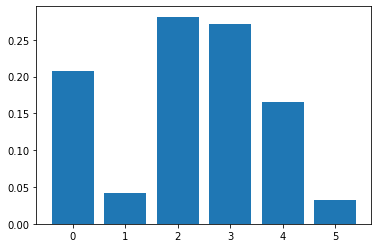

In [19]:
# Define the model
model_rf = RandomForestClassifier(n_estimators=150, max_depth=10, max_features=None, random_state=42)
# Fit the model
model_rf.fit(x_train, y_train)
# Get importance
importance = model_rf.feature_importances_
# Summarize feature importance
for name, importance in zip(features.columns, model_rf.feature_importances_):
    print(name, importance)
# Plot feature importance
plt.bar([x for x in range(len(features.columns))], model_rf.feature_importances_)
plt.show()

In [20]:
# evaluate the model
yhat = model_rf.predict(x_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 51.49


We trained a simply random forest classifier and achieved an accuracy of about 51%, which is a small improvement over the baseline. 

When we examine the feature importance plot, we can see that the number of days after vaccination (`NUMDAYS`) and the first symptom listed (`SYMPTOM1_code`) are the two features which most impact the model. The age of the individual is also important but this could be partly a result of the vaccine administration schedule: one vaccine may have been available to older individuals earlier than the other vaccines.

### Implement a grid search for the best hyperparameters

While we have a decent model that improves on the baseeline accuracy, let's see if tuning the hyperparameters and doing a randomized search can improve the accuracy a little bit more.

In [21]:
# Create the random grid

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200]
max_features = ['auto', None, 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [22]:
# Instantiate and define the classifier parameters
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

In [23]:
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', None, 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [5, 10, 25, 50, 75, 100,
                                                         150, 200]},
                   random_state=42, verbose=2)

In [24]:
# Print out the best parameters
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [25]:
# evaluate the model
yhat = rf_random.predict(x_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 52.13


Well, hyperparameter tuning didn't really improve the accuracy of the model. But it was a good exercise in setting up the randomized grid search.

Let's also look at the feature importances.

AGE_YRS 0.28949826182381444
SEX 0.023860311328050783
NUMDAYS 0.1539901564335703
SYMPTOM1_code 0.2659621478961505
SYMPTOM2_code 0.22180034846668875
symptom_num 0.04488877405172516


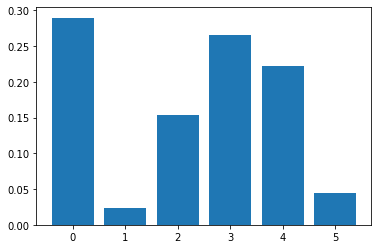

In [26]:
# Summarize feature importance
importances = rf_random.best_estimator_.feature_importances_
for name, importance in zip(features.columns, importances):
    print(name, importance)
# Plot feature importance
plt.bar([x for x in range(len(features.columns))], importances)
plt.show()

The age (`AGE_YRS`) is now the feature with the highest importance, followed by the first symptom (`SYMPTOM1_code`).

We'll save the model and then make a prediction. The symptom codes were obtained by finding the value counts for the top 15 symptoms and then creating a dictionary to match the symptom name to the encoded value. The codes and symptoms are formatted here (words in parentheses are additional explanation).


|**Code 1**| **Symptom 1**|**Code 2**|**Symptom 2**|
|----|:--------------|-----------|:-----------|
|38 | Chills |    113| none|
|10 | Arthralgia (joint pain) |39| Headache|
|50 | Dizziness | 32| Fatigue|
|86 | Injection site erythema| 14| Chills|
|63 | Fatigue| 24| Dizziness|
|70 | Headache| 78| Pain|
|127| Pyrexia (fever)| 88| Pyrexia (fever)|
|11 | Asthenia (weakness)| 53| Injection site pain|
|115| Pain| 74| Nausea|
|58 | Erythema (skin redness)| 79| Pain in extremity|
|111| Nausea| 54| Injection site pruritus|
|116| Pain in extremity| 28| Dyspnoea (shortness of breath)|
|88 | Injection site pain| 72| Myalgia (muscle pain)|
|128| Rash| 87| Pruritus (itchy skin)|
|126| Pruritus (itchy skin)| 89| Rash|

Let's make a prediction! Here I entered my symptoms (which I did not report to VAERS). You can only choose one value for when your symptoms occur - I selected the most significant symptom (Rash) and that this symptom occurred seven days after vaccination.

In [27]:
# Make a prediction
symptom_input =([[43, 0, 7, 128, 113, 1]])
probabilities = rf_random.predict_proba(symptom_input)

print('The probability of J&J: ', probabilities[0][0])
print('The probability of Moderna: ', probabilities[0][1])
print('The probability of Pfizer: ', probabilities[0][2])

The probability of J&J:  0.04284145734822302
The probability of Moderna:  0.8401083997594558
The probability of Pfizer:  0.11705014289232177


The model predicts that I would have received Moderna and in this case, that is correct. But, remembering from the baseline accuracy, we have a 47% chance of being correct by guessing Moderna.

In order to use the pre-trained model in our FastAPI application, we'll use `joblib` to save it.

In [29]:
# Save the model 
from joblib import dump
dump(rf_random, 'trained_model_24may.joblib', compress=3)

['trained_model_24may.joblib']